# # Set 3 — Q7
**Task:** The image contains **small, non‑overlapping blobs**. Segment the blobs using **region growing**.


In [1]:
# %%
# --- Imports & Config ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.segmentation import flood
from scipy import ndimage as ndi

# === User: set your image path here ===
img_path = "../image2.jpg"   

# Parameters
invert_foreground = False   # set True if blobs are darker than background
blur_ksize = 3              # Gaussian blur kernel size (odd)
tolerance = 0.08            # intensity tolerance for region growing (0..1 range)
min_region_area = 20        # remove tiny regions

out_dir = Path("./outputs_q7")
out_dir.mkdir(parents=True, exist_ok=True)

def imshow(ax, img, title="", cmap=None):
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

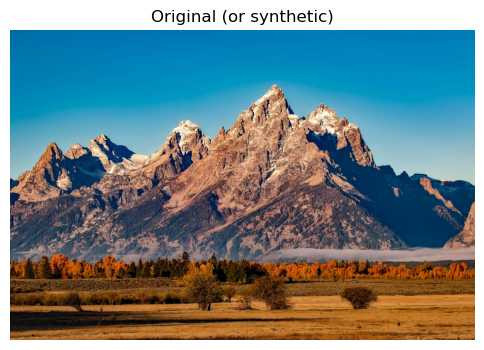

In [2]:
# %%
# --- Load / create image ---
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    # Synthetic non-overlapping blobs (white on black)
    h, w = 400, 600
    synth = np.zeros((h, w), dtype=np.uint8)
    rng = np.random.default_rng(7)
    centers = rng.integers(low=[60,60], high=[w-60, h-60], size=(28,2))
    radii = rng.integers(8, 20, size=centers.shape[0])
    for (cx, cy), r in zip(centers, radii):
        cv2.circle(synth, (int(cx), int(cy)), int(r), 255, -1)
    img_rgb = cv2.cvtColor(synth, cv2.COLOR_GRAY2RGB)
    gray = synth
else:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(6,5))
imshow(ax, img_rgb, "Original (or synthetic)")
plt.show()

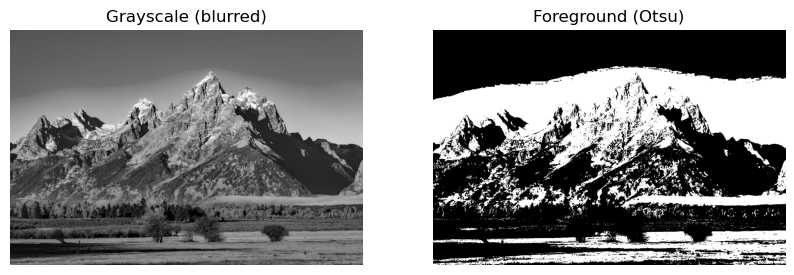

True

In [3]:
# %%
# --- Preprocess & foreground mask (Otsu) ---
gray_f = gray.astype(np.float32) / 255.0
if blur_ksize and blur_ksize >= 3:
    gray_blur = cv2.GaussianBlur(gray_f, (blur_ksize, blur_ksize), 0)
else:
    gray_blur = gray_f

gray_u8 = np.clip(gray_blur * 255, 0, 255).astype(np.uint8)

# Otsu threshold (handle dark blobs by inverting if requested)
flag = cv2.THRESH_BINARY_INV if invert_foreground else cv2.THRESH_BINARY
_, fg = cv2.threshold(gray_u8, 0, 255, flag + cv2.THRESH_OTSU)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(gray_blur, cmap="gray"); plt.title("Grayscale (blurred)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(fg, cmap="gray"); plt.title("Foreground (Otsu)"); plt.axis("off")
plt.show()

cv2.imwrite(str(out_dir / "q7_gray.png"), gray_u8)
cv2.imwrite(str(out_dir / "q7_foreground.png"), fg)

Seed count (auto): 266


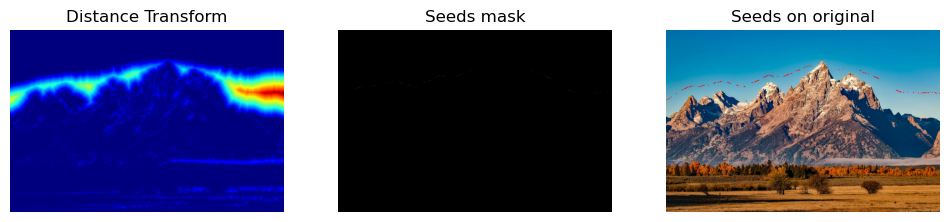

True

In [4]:
# %%
# --- Seeds via distance-transform peaks ---
fg_bin = (fg > 0).astype(np.uint8)
dist = cv2.distanceTransform(fg_bin, cv2.DIST_L2, 3)

# Find local maxima of distance map as seeds
# Smooth a bit, then detect regional maxima
dist_smooth = cv2.GaussianBlur(dist, (3,3), 0)
footprint = np.ones((3,3), dtype=bool)
local_max = (dist_smooth == ndi.maximum_filter(dist_smooth, footprint=footprint))
seeds_mask = (local_max & (dist_smooth > dist_smooth.max()*0.25) & (fg_bin.astype(bool)))

seed_coords = np.column_stack(np.nonzero(seeds_mask))
print(f"Seed count (auto): {len(seed_coords)}")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(dist, cmap="jet"); plt.title("Distance Transform"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(seeds_mask, cmap="gray"); plt.title("Seeds mask"); plt.axis("off")
overlay = img_rgb.copy()
for (y,x) in seed_coords:
    cv2.circle(overlay, (int(x), int(y)), 3, (255,0,0), -1)
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Seeds on original"); plt.axis("off")
plt.show()

cv2.imwrite(str(out_dir / "q7_dist.png"), (255*dist/dist.max()).astype(np.uint8))
cv2.imwrite(str(out_dir / "q7_seeds.png"), (seeds_mask*255).astype(np.uint8))

Region-growing labels: 3 regions


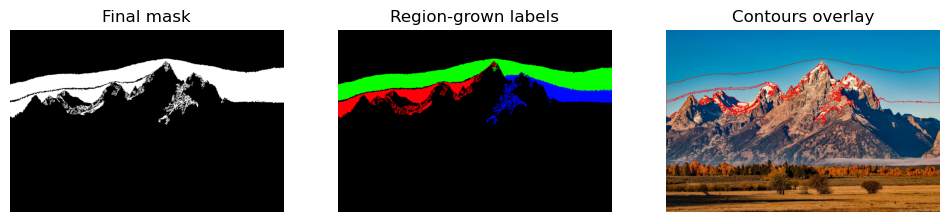

True

In [5]:
# %%
# --- Region growing with skimage.segmentation.flood ---
labels = np.zeros_like(gray_u8, dtype=np.int32)
current_label = 0
used = np.zeros_like(gray_u8, dtype=bool)

for (y, x) in seed_coords:
    if used[y, x]:
        continue
    # Grow only inside foreground
    mask = flood(gray_blur, (int(y), int(x)), tolerance=tolerance)
    mask &= fg_bin.astype(bool)
    # Remove overlap with previously accepted regions
    mask &= (~used)
    area = int(mask.sum())
    if area >= min_region_area:
        current_label += 1
        labels[mask] = current_label
        used[mask] = True

print(f"Region-growing labels: {current_label} regions")

# Build a colored visualization
label_hues = (labels.astype(np.float32) / max(1, current_label)) * 179
blank_ch = 255 * np.ones_like(labels, dtype=np.uint8)
hsv = np.dstack([label_hues.astype(np.uint8), blank_ch, (labels>0).astype(np.uint8)*255])
label_color = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow((used>0), cmap="gray"); plt.title("Final mask"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(label_color); plt.title("Region-grown labels"); plt.axis("off")
ov = img_rgb.copy()
contours, _ = cv2.findContours((labels>0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(ov, contours, -1, (255,0,0), 2)
plt.subplot(1,3,3); plt.imshow(ov); plt.title("Contours overlay"); plt.axis("off")
plt.show()

cv2.imwrite(str(out_dir / "q7_labels_color.png"), cv2.cvtColor(label_color, cv2.COLOR_RGB2BGR))
cv2.imwrite(str(out_dir / "q7_overlay.png"), cv2.cvtColor(ov, cv2.COLOR_RGB2BGR))

In [6]:
# %%
# --- Simple measurements (areas, centroids) ---
num_labels, cclabels, stats, centroids = cv2.connectedComponentsWithStats((labels>0).astype(np.uint8), connectivity=8)
blob_count = num_labels - 1
areas = stats[1:, cv2.CC_STAT_AREA]
print(f"Blob count (connected components over grown regions): {blob_count}")
print("Areas (first 10):", areas[:10])
print("Centroids (first 10):", centroids[1:11])

Blob count (connected components over grown regions): 1
Areas (first 10): [431457]
Centroids (first 10): [[1139.96751472  446.85684784]]
